In [35]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import numpy as np

json_file = 'Data\squat_golden_repetition.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)

for key, value in data.items():
    print(key, value)

config {'iou_threshold': 0.5, 'limb_activity_threshold': 0.25, 'node_axis_threshold': 0.15, 'number_points_displayed': 5}
used_nodes [{'name': 'NOSE', 'index': 0}, {'name': 'LEFT_EYE', 'index': 1}, {'name': 'RIGHT_EYE', 'index': 2}, {'name': 'LEFT_EAR', 'index': 3}, {'name': 'RIGHT_EAR', 'index': 4}, {'name': 'LEFT_SHOULDER', 'index': 5}, {'name': 'RIGHT_SHOULDER', 'index': 6}, {'name': 'LEFT_ELBOW', 'index': 7}, {'name': 'RIGHT_ELBOW', 'index': 8}, {'name': 'LEFT_WRIST', 'index': 9}, {'name': 'RIGHT_WRIST', 'index': 10}, {'name': 'LEFT_HIP', 'index': 11}, {'name': 'RIGHT_HIP', 'index': 12}, {'name': 'LEFT_KNEE', 'index': 13}, {'name': 'RIGHT_KNEE', 'index': 14}, {'name': 'LEFT_FOOT', 'index': 15}, {'name': 'RIGHT_FOOT', 'index': 16}]
affine_transform_nodes [{'name': 'NOSE', 'index': 0}, {'name': 'LEFT_HIP', 'index': 11}, {'name': 'RIGHT_HIP', 'index': 12}]
evaluation_nodes [{'name': 'LEFT_WRIST', 'index': 9}, {'name': 'RIGHT_WRIST', 'index': 10}]
golden_rep_poses [{'timestamp': 0, 'po

In [36]:
def get_body_parts(data):
    """
    This function returns 'body_parts' dictionary, that links the name of the body part, with its index.
    """
    try:
        body_parts = {node['name']: node['index'] for node in data['used_nodes']}
    except KeyError:
        # Some exercises (f.e. 'D1_flexion) do not contain the 'used_nodes' key, so let's assume the following:
        body_parts = {
            'NOSE': 0,
            'LEFT_EYE': 1,
            'RIGHT_EYE': 2,
            'LEFT_EAR': 3,
            'RIGHT_EAR': 4,
            'LEFT_SHOULDER': 5,
            'RIGHT_SHOULDER': 6,
            'LEFT_ELBOW': 7,
            'RIGHT_ELBOW': 8,
            'LEFT_WRIST': 9,
            'RIGHT_WRIST': 10,
            'LEFT_HIP': 11,
            'RIGHT_HIP': 12,
            'LEFT_KNEE': 13,
            'RIGHT_KNEE': 14,
            'LEFT_FOOT': 15,
            'RIGHT_FOOT': 16
        }
    return body_parts

def get_list_of_positions(data):
    """
    This function preprocesses the 'golden_rep_poses' key into a list of frames.
    Each frame is a list of tuples (x, y) representing the position of each node.
    """
    list_of_positions = []
    for timestamp in data['golden_rep_poses']:
        positions = timestamp['pose']
        list_of_tuples_for_each_timestamp = [
            [positions[i], positions[i+1]] for i in range(0, 34, 2)
        ]
        list_of_positions.append(list_of_tuples_for_each_timestamp)
    return list_of_positions

def transform_list_of_positions(list_of_positions):
    """the function can be extended, for now I need only to reflect the node by liney=0.5, as the image is
    upside-down
    
    When we will need to add a scale it's a good place to do so.
    
    """
    for frame in list_of_positions:
        for node in frame:
            node[1] = -node[1]+1
            # print(node)

    return list_of_positions


def add_fake_point_between_A_and_B(A, B, list_of_positions, body_parts, name):
    """
    Adds a fake point between points A and B and appends it to each frame in list_of_positions.
    """
    for frame in list_of_positions:
        fake_point_x = (frame[body_parts[A]][0] + frame[body_parts[B]][0]) / 2
        fake_point_y = (frame[body_parts[A]][1] + frame[body_parts[B]][1]) / 2
        frame.append((fake_point_x, fake_point_y))
    body_parts[name] = len(body_parts)

def get_trace(node, list_of_positions, body_parts):
    trace = []
    node_index = body_parts[node]
    for frame in list_of_positions:
        trace.append(frame[node_index])

    return trace

import math
def get_angle(A, B, C, list_of_positions, body_parts):
    angles = []
    for frame in list_of_positions:
        a = frame[body_parts[A]]
        b = frame[body_parts[B]]
        c = frame[body_parts[C]]

        BA = [a[0] - b[0], a[1] - b[1]]
        BC = [c[0] - b[0], c[1] - b[1]]
        
        # Dot product of BA and BC
        dot_product = BA[0] * BC[0] + BA[1] * BC[1]
        
        # Magnitudes of BA and BC
        magnitude_BA = math.sqrt(BA[0]**2 + BA[1]**2)
        magnitude_BC = math.sqrt(BC[0]**2 + BC[1]**2)
        
        # Cosine of the angle
        cos_angle = dot_product / (magnitude_BA * magnitude_BC)
        
        # Angle in radians
        angle_radians = math.acos(cos_angle)
        
        # Convert to degrees
        angle_degrees = math.degrees(angle_radians)
        angles.append(angle_degrees)

    return angles


HUMAN_BLUEPRINT = [
    ('LEFT_SHOULDER', 'LEFT_ELBOW'), ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'), ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('RIGHT_SHOULDER', 'LEFT_SHOULDER'), ('RIGHT_HIP', 'LEFT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'), ('LEFT_KNEE', 'LEFT_FOOT'),
    ('RIGHT_HIP', 'RIGHT_KNEE'), ('RIGHT_KNEE', 'RIGHT_FOOT')
]


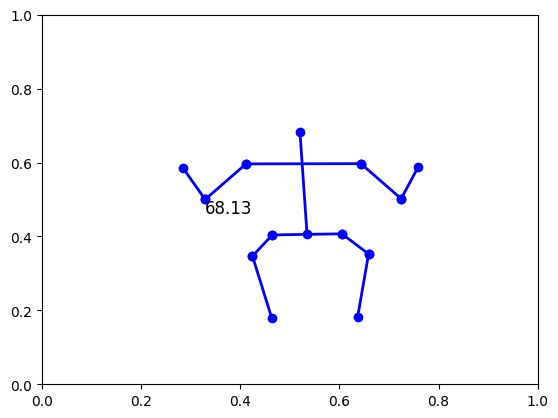

[64.61075945989579, 64.26354741409814, 64.11167070900561, 64.55784748852588, 64.87361878240148, 64.24759090032963, 64.34329314048318, 64.31286979827966, 64.18528550424321, 64.78828166816929, 64.11478627290865, 63.60775301556129, 64.62714380694098, 60.767010963580994, 61.64787188415569, 61.19700713961001, 63.829356134285156, 70.69352591447216, 75.46218295080172, 82.76584148356545, 87.30628586173611, 93.73462228130566, 97.59403280049459, 105.90011675342897, 111.14064803602037, 118.26071449907005, 125.55062391081633, 133.80482511813491, 140.9317976329672, 145.73984560655046, 149.95728949380126, 156.80525579476728, 163.1865601152832, 165.10419633163713, 169.06381706498598, 170.5975261955752, 171.97836402725267, 173.71536174525264, 171.66258323591546, 172.0581406027761, 172.94680424105346, 173.91458961144062, 173.8870370718324, 173.91290708337706, 174.25760076175678, 174.2347183451262, 172.96944312865074, 175.0725515558748, 175.46396320525972, 175.38657140411942, 175.18060812989566, 175.362

In [37]:
body_parts = get_body_parts(data)
list_of_positions = get_list_of_positions(data)
list_of_positions = transform_list_of_positions(list_of_positions)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')

trace = get_trace('LEFT_ELBOW', list_of_positions, body_parts)

# Add the connection from the MID_HIP to the NOSE 
HUMAN_BLUEPRINT.append(('MID_HIP', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in HUMAN_BLUEPRINT]


angles = get_angle('LEFT_SHOULDER', 'LEFT_ELBOW', 'LEFT_WRIST', list_of_positions, body_parts)
# print(angles)

fig, ax = plt.subplots()
ax.set_xlim(0, 1) 
ax.set_ylim(0, 1) 

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
angle_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=12, verticalalignment='top')




def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)

    if i < len(trace):
        current_angle = angles[i]
        angle_text.set_text(f'{round(current_angle, 3)}')
        angle_text.set_position((trace[i][0], trace[i][1]))


    return lines 

# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)

gif_path = 'Angles_animations/'+json_file[5:-5] + '_angle_animation.gif'
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()

print(angles)
print(min(angles))
print(max(angles))

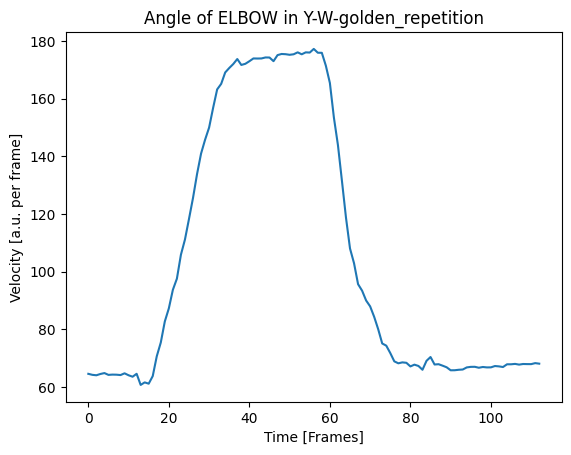

In [38]:
plt.title(f'Angle of ELBOW in {json_file[5:-5]}')
plt.plot(angles)
plt.xlabel('Time [Frames]')
plt.ylabel('Velocity [a.u. per frame]')


plt.savefig(f'Plots/Angle of ELBOW in {json_file[5:-5]}.png')